In [ ]:
# predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train=pd.read_csv('Train.csv')
rider=pd.read_csv('Riders.csv')
rider.drop(['Age'],axis=1,inplace=True)

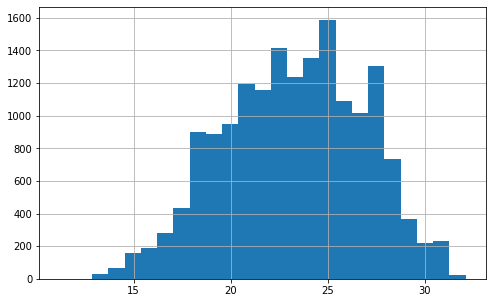

In [ ]:
hist_temp = train.Temperature.hist(bins=25,figsize=[8,5])

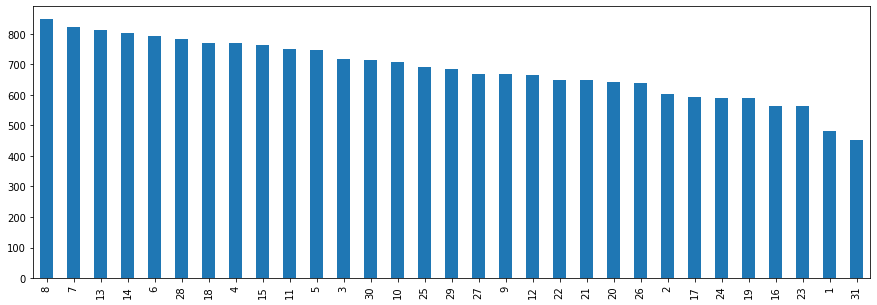

In [ ]:
train['Arrival at Pickup - Day of Month'].value_counts().plot(kind='bar',figsize=[15,5])

In [ ]:
data=pd.merge(train,rider,on='Rider Id',how='left')

In [ ]:
data.drop(['Order No','Rider Id','Vehicle Type','Precipitation in millimeters'],axis=1,inplace=True)

In [ ]:
data.shape

(21201, 28)

In [ ]:
class CFG :
  catboost_params = {'learning_rate' :0.05,'iterations':10000,'random_seed':0,
                     'use_best_model':True,'verbose':100,
                     'task_type':"GPU",'devices':'0:1' }
  catfs    = ['order_id','client_id','rider_id','client_type']
  to_drop  = ['ID','target','vendor_type','dispatch_time',"dispatch_hour"]
  tts_seed = 3031
  tts_ts   = 0.2

In [ ]:
cat_cols = list(data.columns[data.dtypes=='object'])
len(cat_cols)

7

In [ ]:
data[cat_cols].head(2)

,User Id,Personal or Business,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time
0,User_Id_633,Business,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM,10:39:55 AM
1,User_Id_2285,Personal,11:16:16 AM,11:23:21 AM,11:40:22 AM,11:44:09 AM,12:17:22 PM


In [ ]:
data['Personal or Business']=data['Personal or Business'].replace({'Personal':1,'Business':0})

In [ ]:
data['Placement_time'] = pd.to_datetime(data['Placement - Time'])
data['placement_hour'] = data['Placement_time'].dt.hour
data['Confirmation_time'] = pd.to_datetime(data['Confirmation - Time'])
data['Confirmation_hour'] = data['Confirmation_time'].dt.hour
data['arrivalpickup_time'] = pd.to_datetime(data['Arrival at Pickup - Time'])
data['arrivalpickup_hour'] = data['arrivalpickup_time'].dt.hour
data['pickup_time'] = pd.to_datetime(data['Pickup - Time'])
data['pickup_hour'] = data['pickup_time'].dt.hour
data['destination'] = pd.to_datetime(data['Arrival at Destination - Time'])
data['pickup_hour'] = data['destination'].dt.hour
data.drop(['Placement - Time','Confirmation - Time','Arrival at Pickup - Time','Pickup - Time','Arrival at Destination - Time'],axis=1,inplace=True)
#'Placement - Time','Confirmation - Time','Arrival at Pickup - Time','Pickup - Time','Arrival at Destination - Time'

In [ ]:
data.drop(['Placement_time','Confirmation_time','arrivalpickup_time','pickup_time','destination'],axis=1,inplace=True)

In [ ]:
data.head(1)

,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,...,Destination Lat,Destination Long,Time from Pickup to Arrival,No_Of_Orders,Average_Rating,No_of_Ratings,placement_hour,Confirmation_hour,arrivalpickup_hour,pickup_hour
0,User_Id_633,3,0,9,5,9,5,9,5,9,...,-1.300406,36.829741,745,1637,13.8,549,9,9,10,10


In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE_features = ['User Id']
for feature in LE_features :
  data[feature] = LE.fit_transform(data[feature].astype(str))

In [ ]:
X=data.drop(['User Id','Time from Pickup to Arrival'],axis=1)
y=train['Time from Pickup to Arrival']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import pickle
model=LGBMRegressor()
model.fit(X_train,y_train)
np.sqrt(mean_squared_error(y_test,model.predict(X_test)))

680.7579246884577

In [ ]:
pickle.dump(model,open('ArrivalTimePredictor.pkl','wb'))